In [1]:
import os
import subprocess
import shutil
import fileinput

import rasterio
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import fiona
import rasterio
from rasterio.mask import mask
from rasterio.mask import raster_geometry_mask
from osgeo import gdal

# Run LSDTT command-line script to get advanced hillslope metrics

includes making driver files for each tile. 'advdriver.driver' was a driver file I made ahead of time. I will probably go back and tune some of that.

This will take a while. It will also appear in your terminal.

In [2]:
for fname in os.listdir("."):
        if "_UTM.tif" in fname and "tile" in fname:
                position=fname.index('.')
                filename=fname[0:position]
                print("Getting hilltop data on " + (os.path.join(".", fname)))

                #Need .bils. Shouldn't have deleted them! 
                gdal_string = "gdal_translate -of ENVI " + fname + " " + filename + ".bil"
                os.system(gdal_string)
                
                #Replace the driver file's read and write file name with the ucrrent filename
                shutil.copy("advdriver.driver", filename+"_adv.driver")
                for line in fileinput.input(filename+"_adv.driver", inplace=True): 
                    print(line.rstrip().replace("read fname: fname", "read fname: " + filename))
                for line in fileinput.input(filename+"_adv.driver", inplace=True): 
                    print(line.rstrip().replace("write fname: fname", "write fname: " + filename))
                
                #Insert a channel head file for each tile. W sources looked the nicest, but you should run it for other ones
                for line in fileinput.input(filename+"_adv.driver", inplace=True): 
                    print(line.rstrip().replace("CHeads_file: CHeads_fname", "CHeads_file: " + filename + "_Dsources"))
                
                #Run channel head extraction command line script
                lsd_string="lsdtt-hillslope-channel-coupling " + filename+"_adv.driver"
                os.system(lsd_string)

Getting hilltop data on ./tile_0_UTM.tif
Getting hilltop data on ./tile_10_UTM.tif
Getting hilltop data on ./tile_11_UTM.tif
Getting hilltop data on ./tile_12_UTM.tif
Getting hilltop data on ./tile_13_UTM.tif
Getting hilltop data on ./tile_14_UTM.tif
Getting hilltop data on ./tile_15_UTM.tif
Getting hilltop data on ./tile_16_UTM.tif
Getting hilltop data on ./tile_17_UTM.tif
Getting hilltop data on ./tile_18_UTM.tif
Getting hilltop data on ./tile_19_UTM.tif
Getting hilltop data on ./tile_20_UTM.tif
Getting hilltop data on ./tile_21_UTM.tif
Getting hilltop data on ./tile_22_UTM.tif
Getting hilltop data on ./tile_23_UTM.tif
Getting hilltop data on ./tile_24_UTM.tif
Getting hilltop data on ./tile_25_UTM.tif
Getting hilltop data on ./tile_26_UTM.tif
Getting hilltop data on ./tile_27_UTM.tif
Getting hilltop data on ./tile_28_UTM.tif
Getting hilltop data on ./tile_29_UTM.tif
Getting hilltop data on ./tile_2_UTM.tif
Getting hilltop data on ./tile_30_UTM.tif
Getting hilltop data on ./tile_31_UT

In [3]:
#Make an empty dictionary 
tile_dict = {}

for fname in os.listdir("."):
        if "HilltopData.csv" in fname:
                csvname=fname
                
                print('Getting stats on ' + fname)
                position=fname.index('.')
                #I'm so sorry this is what I have to do
                #There must be a better way
                if fname[6]=="_":
                    tilename=fname[0:6]
                else:
                    tilename=fname[0:7]
                
                df=pd.read_csv(csvname)
                                           
                #get coordinates from the sources csv
                coords = [(easting, northing) for easting, northing in zip(df.easting, df.northing)]        
                #df['dinf_area'] = [x[0] for x in dinf_src.sample(coords)]
                
                #definitely need to write a program for this. 
                gdem = gdal.Open(tilename + '_UTM.tif', gdal.GA_ReadOnly)
                proj = gdem.GetProjection()
                #So it looks like LSDTT might get the projection but I don't know how to tap that so I literally just
                #grab from this massive unformatted string the UTM zone from the gdal command
                proj=(proj[20:32])

                if '17N' in proj:
                    with fiona.open("Tuscarora_17N.shp", "r") as shapefile:
                        Tuscarora_mask = [feature["geometry"] for feature in shapefile]
                #    print('17N')
                elif '18N' in proj:
                    with fiona.open("Tuscarora_18N.shp", "r") as shapefile:
                        Tuscarora_mask = [feature["geometry"] for feature in shapefile]
                #    print('18N')
                else:
                    print('u r fucked') #I was very frustrated


                #Bless me father for I have sinned, this is the only way I could 
                #do a logical for whether a point is within the Tuscarora
                #Appears that Shapely should do it but it didn't like my shapefile being in 
                #a lot of pieces. I decided I'd rather get the answer the ugly way
                dem = rasterio.open(tilename + '_UTM.tif')

                out_image, out_transform = rasterio.mask.mask(dem, Tuscarora_mask)
                out_meta = dem.meta
                out_meta.update({"driver": "GTiff",
                              "height": out_image.shape[1],
                              "width": out_image.shape[2],
                              "transform": out_transform})

                #Write a raster, close it, then open it...I'm sure this is not correct. 
                profile = dem.profile       
                mask_ds= rasterio.open('mask_raster.tif', 'w', **profile)
                mask_ds.write(out_image[0], 1)
                mask_ds.close()
                masktest = rasterio.open('mask_raster.tif')

                #now you use pandas
                df['within_tusc'] = [easting[0] for easting in masktest.sample(coords)]
                df['within_tusc'] = np.where(df['within_tusc']< 0, False, True)
                df_stats = df.groupby('within_tusc').describe()
                tile_dict[tilename] = df_stats

Getting stats on tile_0_UTM_HilltopData.csv
Getting stats on tile_10_UTM_HilltopData.csv
Getting stats on tile_11_UTM_HilltopData.csv
Getting stats on tile_12_UTM_HilltopData.csv
Getting stats on tile_13_UTM_HilltopData.csv
Getting stats on tile_14_UTM_HilltopData.csv
Getting stats on tile_16_UTM_HilltopData.csv
Getting stats on tile_17_UTM_HilltopData.csv
Getting stats on tile_18_UTM_HilltopData.csv
Getting stats on tile_19_UTM_HilltopData.csv
Getting stats on tile_20_UTM_HilltopData.csv
Getting stats on tile_21_UTM_HilltopData.csv
Getting stats on tile_22_UTM_HilltopData.csv
Getting stats on tile_23_UTM_HilltopData.csv
Getting stats on tile_24_UTM_HilltopData.csv
Getting stats on tile_25_UTM_HilltopData.csv
Getting stats on tile_26_UTM_HilltopData.csv
Getting stats on tile_27_UTM_HilltopData.csv
Getting stats on tile_28_UTM_HilltopData.csv
Getting stats on tile_29_UTM_HilltopData.csv
Getting stats on tile_2_UTM_HilltopData.csv
Getting stats on tile_30_UTM_HilltopData.csv
Getting stat

In [14]:
means = []
for tilename in tile_dict.keys():
    if tile_dict[tilename].shape[0] > 1: #Some tiles didn't have Tuscarora hillslopes measured
        mean1, std1 = tile_dict[tilename].loc[True,'Lh'][['mean','std']].values
        mean2, std2 = tile_dict[tilename].loc[False,'Lh'][['mean','std']].values
        means.append([tilename, mean1, std1, mean2, std2])
df_means = pd.DataFrame(means, columns = ['tile','Tusc_mean', 'Tusc_std', 'nTusc_mean', 'nTusc_std'])

In [15]:
dflats = pd.read_csv('tile_lats.csv')

In [16]:
df_means = df_means.merge(dflats, how='left', on='tile')
df_means.to_csv('Dsources_hilltop_geology_data.csv', index=False)
df_means

,tile,Tusc_mean,Tusc_std,nTusc_mean,nTusc_std,latitude,jan_mean,map
0,tile_0,690.401218,197.223548,256.506209,169.841038,40.099300,-1.879193,1024.868568
1,tile_10,541.872181,415.475857,472.300096,397.073532,39.424099,-1.203168,977.814222
2,tile_11,339.957517,272.926460,253.716743,173.330765,39.596401,-0.811104,965.363570
3,tile_13,587.279172,286.501450,308.233048,218.861845,39.870998,-2.521358,1009.830927
4,tile_16,823.783714,243.436024,281.250452,247.257646,40.397098,-2.346220,1084.007437
5,tile_17,581.114530,150.730085,199.017149,158.627999,40.312401,-2.048537,1081.586404
6,tile_18,972.182692,59.556156,277.731145,204.362901,40.488899,-2.890427,1014.427376
7,tile_19,674.667040,278.056722,376.669441,265.041465,40.169701,-2.656420,1011.531174
8,tile_20,972.549246,429.996957,332.610330,257.426440,40.504501,-2.351266,1070.396012
9,tile_21,662.274580,136.367939,440.263694,246.739915,40.375999,-3.384573,1031.240976


<ErrorbarContainer object of 3 artists>

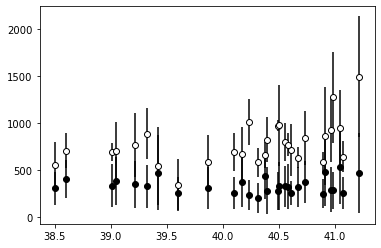

In [7]:
fig, ax = plt.subplots()
ax.errorbar(df_means['latitude'],df_means['Tusc_mean'], yerr=df_means['Tusc_std'], fmt='o', markerfacecolor='white',c='k')
ax.errorbar(df_means['latitude'],df_means['nTusc_mean'], yerr=df_means['nTusc_std'], fmt='o', c='k')

<ErrorbarContainer object of 3 artists>

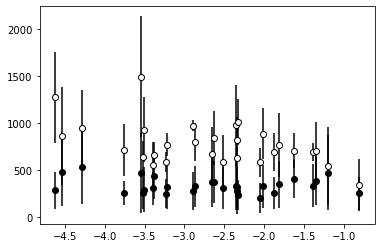

In [8]:
fig, ax = plt.subplots()
ax.errorbar(df_means['jan_mean'],df_means['Tusc_mean'], yerr=df_means['Tusc_std'], fmt='o', markerfacecolor='white',c='k')
ax.errorbar(df_means['jan_mean'],df_means['nTusc_mean'], yerr=df_means['nTusc_std'], fmt='o', c='k')

<ErrorbarContainer object of 3 artists>

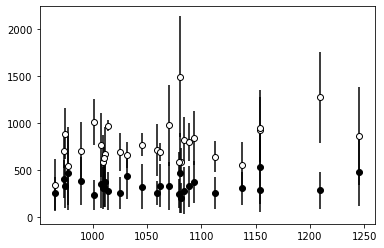

In [9]:
fig, ax = plt.subplots()
ax.errorbar(df_means['map'],df_means['Tusc_mean'], yerr=df_means['Tusc_std'], fmt='o', markerfacecolor='white',c='k')
ax.errorbar(df_means['map'],df_means['nTusc_mean'], yerr=df_means['nTusc_std'], fmt='o', c='k')

<ErrorbarContainer object of 3 artists>

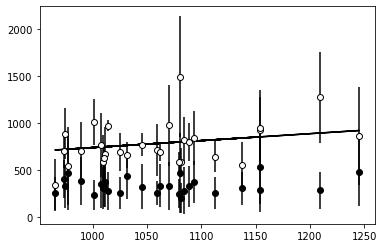

In [10]:
from scipy.optimize import curve_fit
fig, ax = plt.subplots()
x1 = df_means['map'].values
y1 = df_means['Tusc_mean'].values
def d1(x, a):
    return a*x + 0
popt1, pcov1 = curve_fit(d1, x1, y1)
residuals = y1 - d1(x1, *popt1)  
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y1-np.mean(y1))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.plot(x1, d1(x1, *popt1), 'k-')
#ax.annotate(str(round(r_squared,2)),
#               xy=(1.45,d1(1.45, *popt1)),va='bottom',ha='right')
ax.errorbar(df_means['map'],df_means['Tusc_mean'], yerr=df_means['Tusc_std'], fmt='o', markerfacecolor='white',c='k')
ax.errorbar(df_means['map'],df_means['nTusc_mean'], yerr=df_means['nTusc_std'], fmt='o', c='k')

<ErrorbarContainer object of 3 artists>

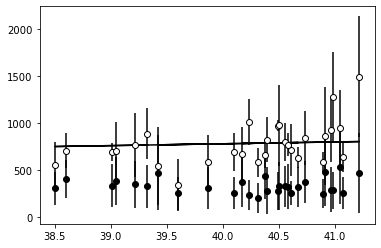

In [11]:
from scipy.optimize import curve_fit
fig, ax = plt.subplots()
x1 = df_means['latitude'].values
y1 = df_means['Tusc_mean'].values
def d1(x, a):
    return a*x + 0
popt1, pcov1 = curve_fit(d1, x1, y1)
residuals = y1 - d1(x1, *popt1)  
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y1-np.mean(y1))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.plot(x1, d1(x1, *popt1), 'k-')
#ax.annotate(str(round(r_squared,2)),
#               xy=(1.45,d1(1.45, *popt1)),va='bottom',ha='right')
ax.errorbar(df_means['latitude'],df_means['Tusc_mean'], yerr=df_means['Tusc_std'], fmt='o', markerfacecolor='white',c='k')
ax.errorbar(df_means['latitude'],df_means['nTusc_mean'], yerr=df_means['nTusc_std'], fmt='o', c='k')

<ErrorbarContainer object of 3 artists>

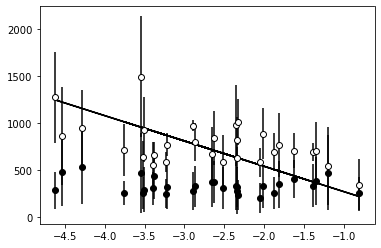

In [12]:
from scipy.optimize import curve_fit
fig, ax = plt.subplots()
x1 = df_means['jan_mean'].values
y1 = df_means['Tusc_mean'].values
def d1(x, a):
    return a*x + 0
popt1, pcov1 = curve_fit(d1, x1, y1)
residuals = y1 - d1(x1, *popt1)  
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y1-np.mean(y1))**2)
r_squared = 1 - (ss_res / ss_tot)
ax.plot(x1, d1(x1, *popt1), 'k-')
#ax.annotate(str(round(r_squared,2)),
#               xy=(1.45,d1(1.45, *popt1)),va='bottom',ha='right')
ax.errorbar(df_means['jan_mean'],df_means['Tusc_mean'], yerr=df_means['Tusc_std'], fmt='o', markerfacecolor='white',c='k')
ax.errorbar(df_means['jan_mean'],df_means['nTusc_mean'], yerr=df_means['nTusc_std'], fmt='o', c='k')